In [10]:
import os
import spaudiopy as spa

Listener not inside: [0 4 5]
Listener not inside: [0 4 5]
Face not pointing towards listener: [0 5 6]
Face not pointing towards listener: [0 7 6]
Face not pointing towards listener: [0 7 8]
Face not pointing towards listener: [0 2 1]
Face not pointing towards listener: [0 4 3]
Face not pointing towards listener: [0 2 3]
Face produces critically large aperture: [ 4  5 12]
Face produces critically large aperture: [ 4 12 11]
Face produces critically large aperture: [11 17 12]
Found large opening angle in face: [11 17 16]


/Users/antonio/opt/anaconda3/lib/python3.9/site-packages/spaudiopy/plots.py:541: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/Users/antonio/opt/anaconda3/lib/python3.9/site-packages/spaudiopy/plots.py:588: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3

TypeError: vbap() got an unexpected keyword argument 'norm'

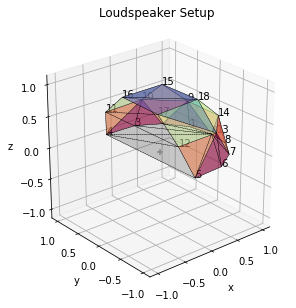

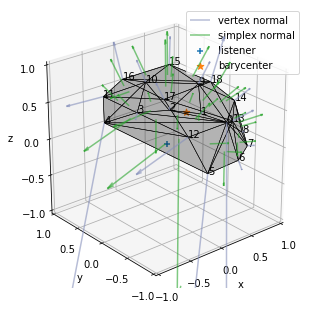

In [12]:

import numpy as np

import matplotlib.pyplot as plt

from spaudiopy import utils, IO, sig, decoder, sph, plots, grids


# %% User setup
setupname = "graz"
LISTEN = True
listener_position = [0, 0, 0]


if setupname == "frontal_partial":
    ls_dirs = np.array([[-80, -45, 0, 45, 80, -60, -30, 30, 60],
                        [0, 0, 0, 0, 0, 60, 60, 60, 60]])
    ls_dirs[1, :] = 90 - ls_dirs[1, :]
    ls_x, ls_y, ls_z = utils.sph2cart(utils.deg2rad(ls_dirs[0, :]),
                                      utils.deg2rad(ls_dirs[1, :]))

    normal_limit = 85
    aperture_limit = 90
    opening_limit = 150
    blacklist = None

    ls_setup = decoder.LoudspeakerSetup(ls_x, ls_y, ls_z, listener_position)
    ls_setup.pop_triangles(normal_limit, aperture_limit, opening_limit,
                           blacklist)

elif setupname == "graz":
    normal_limit = 85
    aperture_limit = 90
    opening_limit = 135
    blacklist = None
    ls_setup = IO.load_layout("./data/ls_layouts/Graz.json",
                              listener_position=listener_position)
    ls_setup.pop_triangles(normal_limit, aperture_limit, opening_limit,
                           blacklist)

else:
    raise ValueError


# %% Show setup
ls_setup.show()
plots.hull_normals(ls_setup)

# Test source location
src = np.array([1, 0.5, 2.5])
src_azi, src_colat, _ = utils.cart2sph(*src.tolist())

# %% VBAP
gains_vbap = decoder.vbap(src, ls_setup, norm=1)  # norm1 because binaural


# %% Ambisonic decoding
# Ambisonic setup
N_e = ls_setup.get_characteristic_order()
ls_setup.ambisonics_setup(update_hull=True, N_kernel=20)

# Show ALLRAP hulls
plots.hull(ls_setup.ambisonics_hull, title='Ambisonic hull')

# ALLRAP
gains_allrap = decoder.allrap(src, ls_setup, N_sph=N_e)
# ALLRAP2
gains_allrap2 = decoder.allrap2(src, ls_setup, N_sph=N_e)
# ALLRAD
input_F_nm = sph.sh_matrix(N_e, src_azi, src_colat, 'real').T  # SH dirac
out_allrad = decoder.allrad(input_F_nm, ls_setup, N_sph=N_e)
out_allrad2 = decoder.allrad2(input_F_nm, ls_setup, N_sph=N_e)


utils.test_diff(gains_allrap, out_allrad, msg="ALLRAD and ALLRAP:")
utils.test_diff(gains_allrap2, out_allrad2, msg="ALLRAD2 and ALLRAP2:")

# Nearest Loudspeaker
gains_nls = decoder.nearest_loudspeaker(src, ls_setup)

# %% test multiple sources
_grid, _weights = grids.load_Fliege_Maier_nodes(10)
G_vbap = decoder.vbap(_grid, ls_setup)
G_allrap = decoder.allrap(_grid, ls_setup)
G_allrap2 = decoder.allrap2(_grid, ls_setup)
G_vbip = decoder.vbip(_grid, ls_setup)

# %% Look at some performance measures
plots.decoder_performance(ls_setup, 'NLS')
plots.decoder_performance(ls_setup, 'VBAP')
plots.decoder_performance(ls_setup, 'VBAP', norm=1, retain_outside=True)
plt.suptitle('VBAP with imaginary loudspeaker and norm1')
plots.decoder_performance(ls_setup, 'VBIP', retain_outside=True)
plt.suptitle('VBIP with imaginary loudspeaker')
plots.decoder_performance(ls_setup, 'EPAD')
plots.decoder_performance(ls_setup, 'ALLRAP')
plots.decoder_performance(ls_setup, 'ALLRAP2')


# %% Binauralize
fs = 44100
hrirs = IO.load_hrirs(fs)

l_vbap_ir, r_vbap_ir = ls_setup.binauralize(ls_setup.loudspeaker_signals(
                                            gains_vbap), fs)

l_allrap_ir, r_allrap_ir = ls_setup.binauralize(ls_setup.loudspeaker_signals(
                                                gains_allrap), fs)
l_allrap2_ir, r_allrap2_ir = ls_setup.binauralize(ls_setup.loudspeaker_signals(
                                                  gains_allrap2), fs)

l_nls_ir, r_nls_ir = ls_setup.binauralize(ls_setup.loudspeaker_signals(
                                          gains_nls), fs)


# %%
fig, axs = plt.subplots(5, 1)
axs[0].plot(hrirs.nearest_hrirs(src_azi, src_colat)[0])
axs[0].plot(hrirs.nearest_hrirs(src_azi, src_colat)[1])
axs[0].set_title("hrir")
axs[1].plot(l_vbap_ir)
axs[1].plot(r_vbap_ir)
axs[1].set_title("binaural VBAP")
axs[2].plot(l_allrap_ir)
axs[2].plot(r_allrap_ir)
axs[2].set_title("binaural ALLRAP")
axs[3].plot(l_allrap2_ir)
axs[3].plot(r_allrap2_ir)
axs[3].set_title("binaural ALLRAP2")
axs[4].plot(l_nls_ir)
axs[4].plot(r_nls_ir)
axs[4].set_title("binaural NLS")
for ax in axs:
    ax.grid(True)
plt.tight_layout()

# Listen to some
s_in = sig.MonoSignal.from_file('./data/piano_mono.flac', fs)
s_in.trim(2.6, 6)

s_out_vbap = sig.MultiSignal(2*[s_in.signal], fs=fs)
s_out_vbap = s_out_vbap.conv([l_vbap_ir, r_vbap_ir])

s_out_allrap = sig.MultiSignal(2*[s_in.signal], fs=fs)
s_out_allrap = s_out_allrap.conv([l_allrap_ir, r_allrap_ir])

s_out_allrap2 = sig.MultiSignal(2*[s_in.signal], fs=fs)
s_out_allrap2 = s_out_allrap2.conv([l_allrap2_ir, r_allrap2_ir])

s_out_hrir = sig.MultiSignal(2*[s_in.signal], fs=fs)
s_out_hrir = s_out_hrir.conv([hrirs.nearest_hrirs(src_azi, src_colat)[0],
                              hrirs.nearest_hrirs(src_azi, src_colat)[1]])


if LISTEN:
    print("input")
    s_in.play()
    print("hrir")
    s_out_hrir.play()
    print("vbap")
    s_out_vbap.play()
    print("allrap")
    s_out_allrap.play()
    print("allrap2")
    s_out_allrap2.play()

    fig = plt.figure()
    fig.add_subplot(5, 1, 1)
    plt.plot(s_in.signal)
    plt.grid(True)
    plt.title("dry")
    fig.add_subplot(5, 1, 2)
    plt.plot(s_out_hrir.get_signals().T)
    plt.grid(True)
    plt.title("hrir")
    fig.add_subplot(5, 1, 3)
    plt.plot(s_out_vbap.get_signals().T)
    plt.grid(True)
    plt.title("binaural VBAP")
    fig.add_subplot(5, 1, 4)
    plt.plot(s_out_allrap.get_signals().T)
    plt.grid(True)
    plt.title("binaural ALLRAP")
    fig.add_subplot(5, 1, 5)
    plt.plot(s_out_allrap2.get_signals().T)
    plt.grid(True)
    plt.title("binaural ALLRAP2")
    plt.tight_layout()

# Auralize with SSR-BRS renderer
IO.write_ssr_brirs_loudspeaker('allrap_brirs.wav',
                               ls_setup.loudspeaker_signals(gains_allrap2),
                               ls_setup, fs)

plt.show()